In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchvision
import os
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

##### 创建图片分类文件夹

In [2]:
base_dir = r"./data/FourWeather/"

In [3]:
if not os.path.isdir(base_dir):
    os.mkdir(base_dir)
    train_dir = os.path.join(base_dir,"train")
    test_dir  = os.path.join(base_dir,"test")
    os.mkdir(train_dir)
    os.mkdir(test_dir)

In [4]:
species = ["cloudy","rain","shine","sunrise"]
for train_or_test in ['train','test']:
    for spec in species:
        if not os.path.exists(os.path.join(base_dir,train_or_test,spec)):
            os.mkdir(os.path.join(base_dir,train_or_test,spec))

##### 从dataset中转移图片到data/FourWeather

In [5]:
img_dir = r"./data/dataset2/"

In [6]:
for i,img in enumerate(os.listdir(img_dir)):
    for spec in species:
        if spec in img:
            if i%5==0:
                s = os.path.join(img_dir,img)
                d = os.path.join(base_dir,"test",spec,img)
            else:
                s = os.path.join(img_dir,img)
                d = os.path.join(base_dir,"train",spec,img)
            shutil.copy(s,d)

##### 读取图片数据

In [7]:
from torchvision import transforms

In [8]:
transform = transforms.Compose([
    transforms.Resize((96,96)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5])
])

In [9]:
BATCH_SIZE = 16

In [10]:
train_ds = torchvision.datasets.ImageFolder(
    os.path.join(base_dir,"train"),
    transform = transform
)

test_ds  = torchvision.datasets.ImageFolder(
    os.path.join(base_dir,"test"),
    transform = transform
)
train_dl   = torch.utils.data.DataLoader(train_ds,batch_size=BATCH_SIZE,shuffle=True)
test_dl    = torch.utils.data.DataLoader(test_ds,batch_size=BATCH_SIZE,shuffle=True)

In [11]:
class_to_id = train_ds.class_to_idx
id_to_class = dict((v,k) for k,v in train_ds.class_to_idx.items())

##### 创建模型  --->添加DropOut层

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv_1  = nn.Conv2d(3,16,(3,3))
        self.conv_2  = nn.Conv2d(16,32,(3,3))
        self.conv_3  = nn.Conv2d(32,64,(3,3))
        self.pool    = nn.MaxPool2d(2,2)
        self.drop    = nn.Dropout(0.5)     # 在Linear层使用Dropout() 默认设置随机丢弃掉的节点的百分比 为 50%
        self.drop2d  = nn.Dropout2d(0.5)   # 在Conv层后面使用DropOut2d
        self.linear_1= nn.Linear(64*10*10,1024)
        self.linear_2= nn.Linear(1024,256)
        self.linear_3= nn.Linear(256,4)
    
    def forward(self,input):
        x = self.conv_1(input)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv_2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv_3(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.drop2d(x)
        x = x.view(-1,x.size(1)*x.size(2)*x.size(3))
        x = self.linear_1(x)
        x = F.relu(x)
        x = self.drop(x)               # 一般在整个神经网络模型的后半部分进行dropout操作
        x = self.linear_2(x)
        x = F.relu(x)
        x = self.drop(x)               # 一般在整个神经网络模型的后半部分进行dropout操作
        x = self.linear_3(x)
        return x

##### 训练模型

In [13]:
model      = Net().to("cuda")
loss_fn    = torch.nn.CrossEntropyLoss()
optim      = torch.optim.Adam(model.parameters(),lr=0.0001)
epoches    = 20

In [14]:
train_loss = []
train_acc  = []
test_loss  = []
test_acc   = []

In [15]:
# model.train()  训练模式 
# model.eval()   预测模式 影响DropOut层 BatchNormalization层 (二者在两种模式下的表现是不同的)

In [16]:
def fit(model,trainloader,testloader,epoch):
    correct = 0       # 记录正确率
    total   = 0       # 记录训练样本总数量
    running_loss = 0
    
    model.train()     # 设置为训练模式 表示DropOut会起作用
    
    for x,y in trainloader:
        if torch.cuda.is_available():
            x,y = x.to("cuda"),y.to("cuda")
        y_pred = model(x)
        loss   = loss_fn(y_pred,y)
        optim.zero_grad()
        loss.backward()
        optim.step()
        with torch.no_grad():
            y_pred = torch.argmax(y_pred,dim=1)
            correct+=(y_pred == y).sum().item()
            total  += y.size(0)
            running_loss += loss.item()
    
    epoch_loss = running_loss / len(trainloader.dataset) # 得到每一个样本在本epoch下的平均loss
    epoch_acc  = correct / total # 得到整个样本的平均预测正确率
    
    test_correct      = 0        # 记录正确率
    test_total        = 0        # 记录训练样本总数量
    test_running_loss = 0
    
    model.eval()                 # 将模型修改为预测模式 表示DropOut失效 注意在验证数据集上不需要进行Dropout
    
    with torch.no_grad():
        for x,y in trainloader:
            if torch.cuda.is_available():
                x,y = x.to("cuda"),y.to("cuda")
            y_pred = model(x)
            loss   = loss_fn(y_pred,y)
            y_pred = torch.argmax(y_pred,dim=1)
            test_correct+=(y_pred == y).sum().item()
            test_total  += y.size(0)
            test_running_loss += loss.item()
    
    epoch_test_loss = test_running_loss / len(testloader.dataset) # 得到每一个样本在本epoch下的平均loss
    epoch_test_acc  = test_correct / test_total                   # 得到整个样本的平均预测正确率
    
    print(
            "epoch:","\t",epoch,"\t",
            "loss: ","\t",round(epoch_loss,3),"\t",
            "accuracy: ","\t",round(epoch_acc,3),"\t",
            "test_loss: ","\t",round(epoch_test_loss,3),"\t",
            "test_accuracy: ","\t",round(epoch_test_acc,3),"\t"
        )
    return epoch_loss,epoch_acc,epoch_test_loss,epoch_test_acc

In [17]:
for epoch in range(epoches):
    epoch_loss,epoch_acc,epoch_test_loss,epoch_test_acc = fit(model,train_dl,test_dl,epoch)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

epoch: 	 0 	 loss:  	 0.079 	 accuracy:  	 0.377 	 test_loss:  	 0.249 	 test_accuracy:  	 0.639 	
epoch: 	 1 	 loss:  	 0.053 	 accuracy:  	 0.659 	 test_loss:  	 0.157 	 test_accuracy:  	 0.742 	
epoch: 	 2 	 loss:  	 0.041 	 accuracy:  	 0.736 	 test_loss:  	 0.128 	 test_accuracy:  	 0.809 	
epoch: 	 3 	 loss:  	 0.035 	 accuracy:  	 0.778 	 test_loss:  	 0.115 	 test_accuracy:  	 0.84 	
epoch: 	 4 	 loss:  	 0.033 	 accuracy:  	 0.792 	 test_loss:  	 0.104 	 test_accuracy:  	 0.854 	
epoch: 	 5 	 loss:  	 0.033 	 accuracy:  	 0.804 	 test_loss:  	 0.101 	 test_accuracy:  	 0.866 	
epoch: 	 6 	 loss:  	 0.029 	 accuracy:  	 0.814 	 test_loss:  	 0.095 	 test_accuracy:  	 0.856 	
epoch: 	 7 	 loss:  	 0.028 	 accuracy:  	 0.839 	 test_loss:  	 0.087 	 test_accuracy:  	 0.88 	
epoch: 	 8 	 loss:  	 0.026 	 accuracy:  	 0.86 	 test_loss:  	 0.082 	 test_accuracy:  	 0.873 	
epoch: 	 9 	 loss:  	 0.026 	 accuracy:  	 0.84 	 test_loss:  	 0.079 	 test_accuracy:  	 0.89 	
epoch: 	 10 	 l

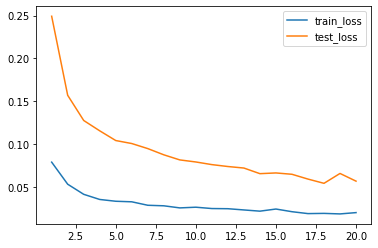

In [18]:
plt.plot(range(1,epoches+1),train_loss,label = "train_loss")
plt.plot(range(1,epoches+1),test_loss,label = "test_loss")
plt.legend()

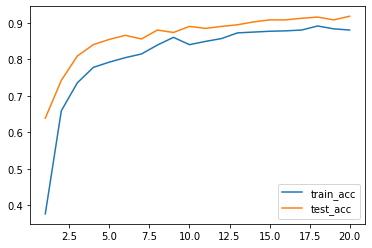

In [19]:
plt.plot(range(1, epoches+1), train_acc, label='train_acc')
plt.plot(range(1, epoches+1), test_acc, label='test_acc')
plt.legend()